In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow import keras

In [2]:
# All mfcc data are contained in numpy_datas, which is a list. 
# The each entry of the list is another list consistes of [mfccs, file name]
MFCCs_DATA = "MFCCsData"
numpy_datas = []

dirlist = os.listdir(MFCCs_DATA)
for d in dirlist:
    d = os.path.join(MFCCs_DATA, d)
    datalist = os.listdir(d)
    datalist = [[np.load(os.path.join(d,x)), os.path.join(d,x)] for x in datalist]
    numpy_datas.extend(datalist)

In [3]:
# find the max size of mfcc and use it to reshape all mfccs into the same shape
mfcc_size = []
for i in range(len(numpy_datas)):
    mfcc_size.append(numpy_datas[i][0].shape[1])
max(mfcc_size)

1117

In [4]:
# resize into (19,1117) and flatten into (19*1117,1)
for i in range(len(numpy_datas)):
    numpy_datas[i][0] = np.resize(np.resize(numpy_datas[i][0], (19,1117)), (19*1117,1))

In [5]:
# change file name to correct label
angry = []
happy = []
normal = []

for i in range(len(numpy_datas)):
    file_name = numpy_datas[i][1]
    if "angry" in file_name:
        numpy_datas[i][1] = np.array([1,0,0])
        angry.append(numpy_datas[i])
    elif "happy" in file_name:
        numpy_datas[i][1] = np.array([0,1,0])
        happy.append(numpy_datas[i])
    else:
        numpy_datas[i][1] = np.array([0,0,1])
        normal.append(numpy_datas[i])

In [6]:
# first shuffle the list of each emotion
random.shuffle(angry)
random.shuffle(happy)
random.shuffle(normal)

In [7]:
# then select the first 180 in each emotion as train data, first 60 in each emotion as valid data, and first 60 in each emotion as test data
train_data = angry[:int(len(angry)*0.6)] + happy[:int(len(happy)*0.6)] + normal[:int(len(normal)*0.6)]
valid_data = angry[int(len(angry)*0.6):int(len(angry)*(0.6+0.2))] + happy[int(len(happy)*0.6):int(len(happy)*(0.6+0.2))] + normal[int(len(normal)*0.6):int(len(normal)*(0.6+0.2))]
test_data = angry[int(len(angry)*(0.6+0.2)):] + happy[int(len(happy)*(0.6+0.2)):] + normal[int(len(normal)*(0.6+0.2)):]
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [8]:
# train, valid, test data are all in list consistes of [mfccs, file name]
# want to change the list to two outputs:
# X: vector of mfccs
# Y: vector of labels
def data2vector(data):
    X = []
    Y = []
    for i in range(len(data)):
        X.append(data[i][0])
        Y.append(data[i][1])
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [9]:
X_train, Y_train = data2vector(train_data)
X_valid, Y_valid = data2vector(valid_data)
X_test, Y_test = data2vector(test_data)

# calcualte mean and standard deviation
X_train_miu = np.average(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

# normalization
X_train_norm = (X_train - X_train_miu)/X_train_std
X_valid_norm = (X_valid - X_train_miu)/X_train_std
X_test_norm = (X_test - X_train_miu)/X_train_std

In [10]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

Now we build a 3 layer neuronetwork: linear -> leakyrelu -> linear -> leakyrelu -> linear -> softmax

In [48]:
dnn_model = Sequential()
dnn_model.add(tfl.Dense(16, input_shape=(1117*19,),
                        kernel_initializer='he_normal', bias_initializer='zeros', 
                        activity_regularizer=tf.keras.regularizers.L2(0.4)
                       )
             )
dnn_model.add(tfl.LeakyReLU(alpha=0.05))
dnn_model.add(tfl.Dense(8, 
                        kernel_initializer='he_normal', bias_initializer='zeros', 
                        activity_regularizer=tf.keras.regularizers.L2(0.4)
                       )
             )
dnn_model.add(tfl.LeakyReLU(alpha=0.05))
dnn_model.add(tfl.Dense(3,
                        kernel_initializer='glorot_normal', bias_initializer='zeros',
                        activity_regularizer=tf.keras.regularizers.L2(0.4)
                       )
             )

In [49]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
dnn_model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 16)                339584    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_31 (Dense)            (None, 8)                 136       
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8)                 0         
                                                                 
 dense_32 (Dense)            (None, 3)                 27        
                                                                 
Total params: 339,747
Trainable params: 339,747
Non-trainable params: 0
_________________________________________________________________


In [104]:
history = dnn_model.fit(X_train_norm, Y_train, epochs=200, batch_size=220, validation_data=(X_valid_norm, Y_valid))

Epoch 1/200
3/3 [==============================] - 0s 31ms/step - loss: 22.3430 - accuracy: 0.3833 - val_loss: 23.7925 - val_accuracy: 0.3111
Epoch 2/200
3/3 [==============================] - 0s 16ms/step - loss: 22.4651 - accuracy: 0.3889 - val_loss: 23.7798 - val_accuracy: 0.3222
Epoch 3/200
3/3 [==============================] - 0s 16ms/step - loss: 22.3682 - accuracy: 0.3944 - val_loss: 23.5450 - val_accuracy: 0.3222
Epoch 4/200
3/3 [==============================] - 0s 18ms/step - loss: 22.2895 - accuracy: 0.3981 - val_loss: 23.4650 - val_accuracy: 0.3222
Epoch 5/200
3/3 [==============================] - 0s 17ms/step - loss: 22.2502 - accuracy: 0.3981 - val_loss: 23.3382 - val_accuracy: 0.3278
Epoch 6/200
3/3 [==============================] - 0s 17ms/step - loss: 22.0659 - accuracy: 0.3926 - val_loss: 23.4807 - val_accuracy: 0.3278
Epoch 7/200
3/3 [==============================] - 0s 16ms/step - loss: 21.9426 - accuracy: 0.3926 - val_loss: 23.4546 - val_accuracy: 0.3278
Epoch 

3/3 [==============================] - 0s 17ms/step - loss: 22.9366 - accuracy: 0.4111 - val_loss: 24.3579 - val_accuracy: 0.2667
Epoch 59/200
3/3 [==============================] - 0s 16ms/step - loss: 22.6551 - accuracy: 0.4148 - val_loss: 24.2507 - val_accuracy: 0.2667
Epoch 60/200
3/3 [==============================] - 0s 18ms/step - loss: 22.5397 - accuracy: 0.4093 - val_loss: 24.1851 - val_accuracy: 0.2722
Epoch 61/200
3/3 [==============================] - 0s 17ms/step - loss: 22.4349 - accuracy: 0.4111 - val_loss: 23.9632 - val_accuracy: 0.2667
Epoch 62/200
3/3 [==============================] - 0s 17ms/step - loss: 22.1477 - accuracy: 0.4093 - val_loss: 23.9947 - val_accuracy: 0.2611
Epoch 63/200
3/3 [==============================] - 0s 18ms/step - loss: 22.1441 - accuracy: 0.4000 - val_loss: 23.7644 - val_accuracy: 0.2667
Epoch 64/200
3/3 [==============================] - 0s 16ms/step - loss: 22.0721 - accuracy: 0.3981 - val_loss: 23.6370 - val_accuracy: 0.2667
Epoch 65/200

3/3 [==============================] - 0s 16ms/step - loss: 19.7231 - accuracy: 0.4407 - val_loss: 22.5305 - val_accuracy: 0.2833
Epoch 116/200
3/3 [==============================] - 0s 16ms/step - loss: 19.7579 - accuracy: 0.4167 - val_loss: 22.3125 - val_accuracy: 0.2722
Epoch 117/200
3/3 [==============================] - 0s 17ms/step - loss: 19.8716 - accuracy: 0.3833 - val_loss: 22.8766 - val_accuracy: 0.2611
Epoch 118/200
3/3 [==============================] - 0s 16ms/step - loss: 20.2469 - accuracy: 0.3704 - val_loss: 23.0116 - val_accuracy: 0.2389
Epoch 119/200
3/3 [==============================] - 0s 17ms/step - loss: 20.6983 - accuracy: 0.3611 - val_loss: 22.9864 - val_accuracy: 0.2389
Epoch 120/200
3/3 [==============================] - 0s 16ms/step - loss: 20.8552 - accuracy: 0.3611 - val_loss: 23.0552 - val_accuracy: 0.2389
Epoch 121/200
3/3 [==============================] - 0s 17ms/step - loss: 20.8539 - accuracy: 0.3667 - val_loss: 22.9879 - val_accuracy: 0.2444
Epoch 

Epoch 172/200
3/3 [==============================] - 0s 17ms/step - loss: 18.3355 - accuracy: 0.4148 - val_loss: 21.6318 - val_accuracy: 0.2500
Epoch 173/200
3/3 [==============================] - 0s 17ms/step - loss: 18.2042 - accuracy: 0.4222 - val_loss: 21.6749 - val_accuracy: 0.2500
Epoch 174/200
3/3 [==============================] - 0s 16ms/step - loss: 18.2276 - accuracy: 0.4278 - val_loss: 21.7116 - val_accuracy: 0.2500
Epoch 175/200
3/3 [==============================] - 0s 17ms/step - loss: 18.1834 - accuracy: 0.4315 - val_loss: 21.7020 - val_accuracy: 0.2500
Epoch 176/200
3/3 [==============================] - 0s 16ms/step - loss: 18.1917 - accuracy: 0.4426 - val_loss: 21.7671 - val_accuracy: 0.2444
Epoch 177/200
3/3 [==============================] - 0s 17ms/step - loss: 18.2144 - accuracy: 0.4426 - val_loss: 21.9172 - val_accuracy: 0.2444
Epoch 178/200
3/3 [==============================] - 0s 16ms/step - loss: 18.2162 - accuracy: 0.4481 - val_loss: 21.8016 - val_accuracy:

C:\Users\zhuq6\AppData\Local\Temp\ipykernel_30488\903421272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\zhuq6\AppData\Local\Temp\ipykernel_30488\903421272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

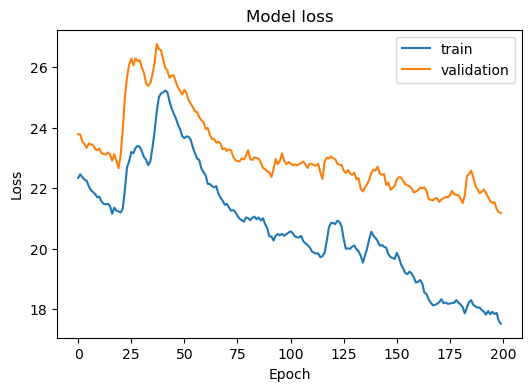

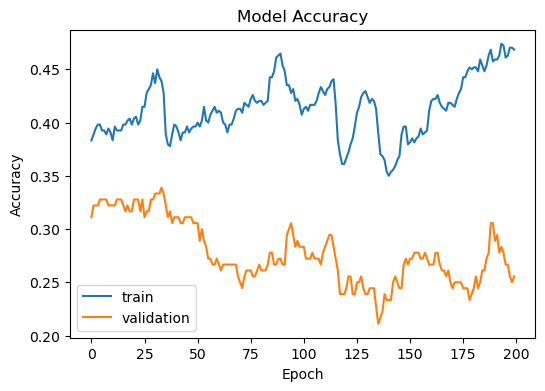

In [105]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')